#A.2. TRANSFER LEARNING & FINE – TUNING MODEL (TENSORFLOW BASED)

#Bài tập thực hành phần Học chuyển giao

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tfds.disable_progress_bar()

# Tải dataset
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Dùng 40% cho train, 10% cho validation, 10% cho test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Bao gồm nhãn
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
print(f"Số lượng mẫu train: {train_ds.cardinality()}")
print(f"Số lượng mẫu validation: {validation_ds.cardinality()}")
print(f"Số lượng mẫu test: {test_ds.cardinality()}")

Số lượng mẫu train: 9305
Số lượng mẫu validation: 2326
Số lượng mẫu test: 2326


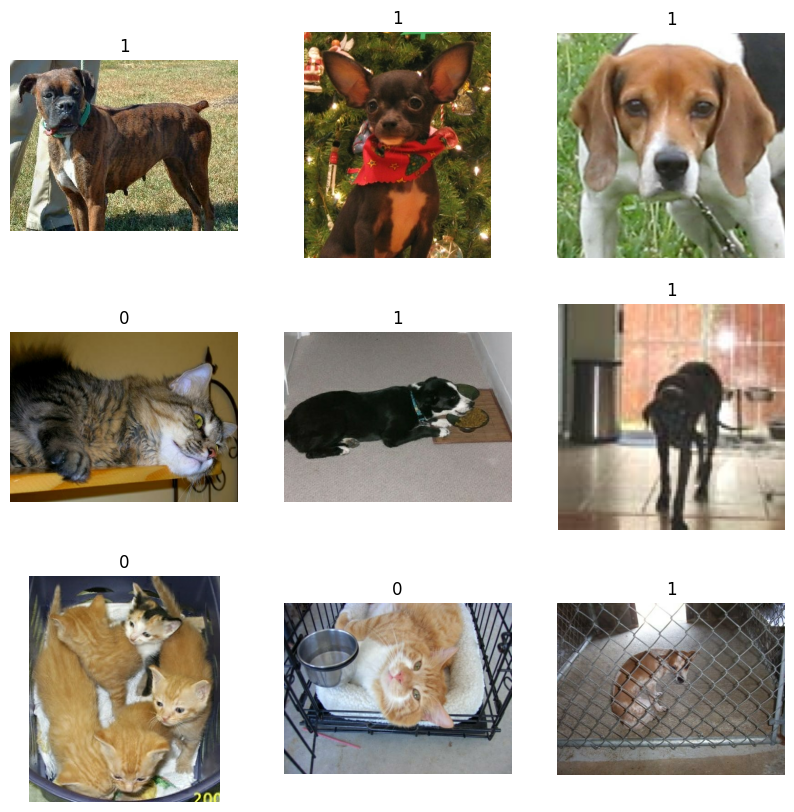

In [ ]:
# Hiển thị một số ảnh mẫu
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
# Resize ảnh
resize_fn = keras.layers.Resizing(150, 150)
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [ ]:
# Data augmentation
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Cấu hình dataset
batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

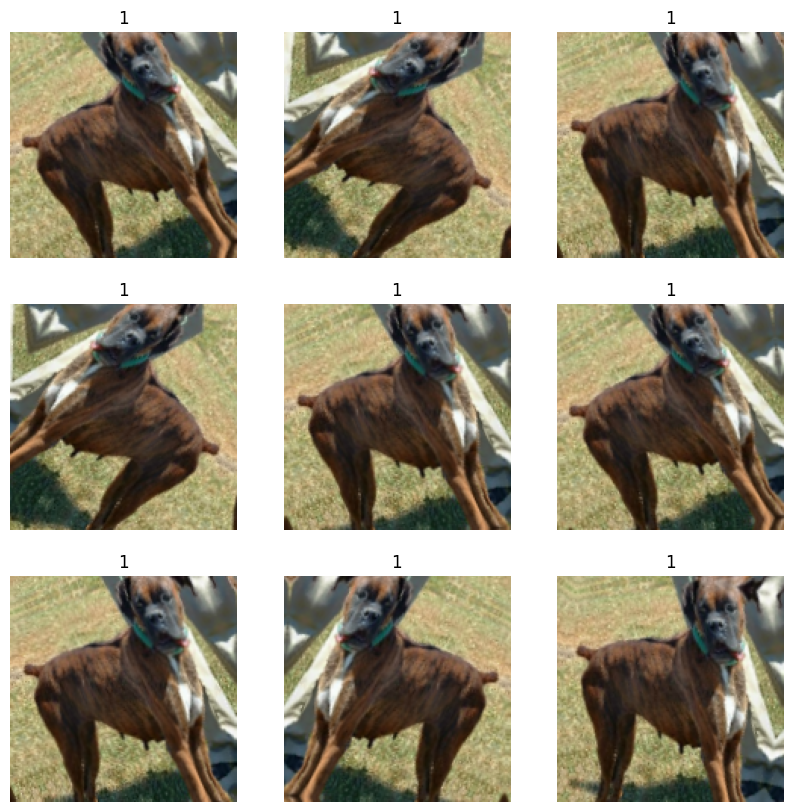

In [ ]:
# Hiển thị ảnh sau khi augment
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# Tạo mô hình base
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)

# Đóng băng base model
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Tạo mô hình mới
inputs = keras.Input(shape=(150, 150, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Biên dịch mô hình
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# Huấn luyện lớp trên cùng
epochs = 10
print("Fitting the top layer of the model")
history_1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 484ms/step - binary_accuracy: 0.8499 - loss: 0.3002 - val_binary_accuracy: 0.9673 - val_loss: 0.0905
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 76s 114ms/step - binary_accuracy: 0.9433 - loss: 0.1343 - val_binary_accuracy: 0.9678 - val_loss: 0.0821
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - binary_accuracy: 0.9483 - loss: 0.1192 - val_binary_accuracy: 0.9695 - val_loss: 0.0786
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - binary_accuracy: 0.9535 - loss: 0.1092 - val_binary_accuracy: 0.9699 - val_loss: 0.0775
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - binary_accuracy: 0.9569 - loss: 0.1061 - val_binary_accuracy: 0.9708 - val_loss: 0.0777
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - binary_accuracy: 0.9621 - loss: 0.0969 - val_binary_accuracy: 0.9708 - val_loss: 0.0791
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - binary_accuracy: 0.9627 - loss: 0.0954

In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 3
print("Fitting the end-to-end model")
history_2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fitting the end-to-end model
Epoch 1/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 132s 569ms/step - binary_accuracy: 0.8616 - loss: 0.3401 - val_binary_accuracy: 0.9622 - val_loss: 0.1014
Epoch 2/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 91s 404ms/step - binary_accuracy: 0.9364 - loss: 0.1644 - val_binary_accuracy: 0.9583 - val_loss: 0.0995
Epoch 3/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 58s 398ms/step - binary_accuracy: 0.9639 - loss: 0.1023 - val_binary_accuracy: 0.9613 - val_loss: 0.0946


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
print("Test dataset evaluation")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Test dataset evaluation
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - binary_accuracy: 0.9585 - loss: 0.0965
Test accuracy: 0.9574
Test loss: 0.1040


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


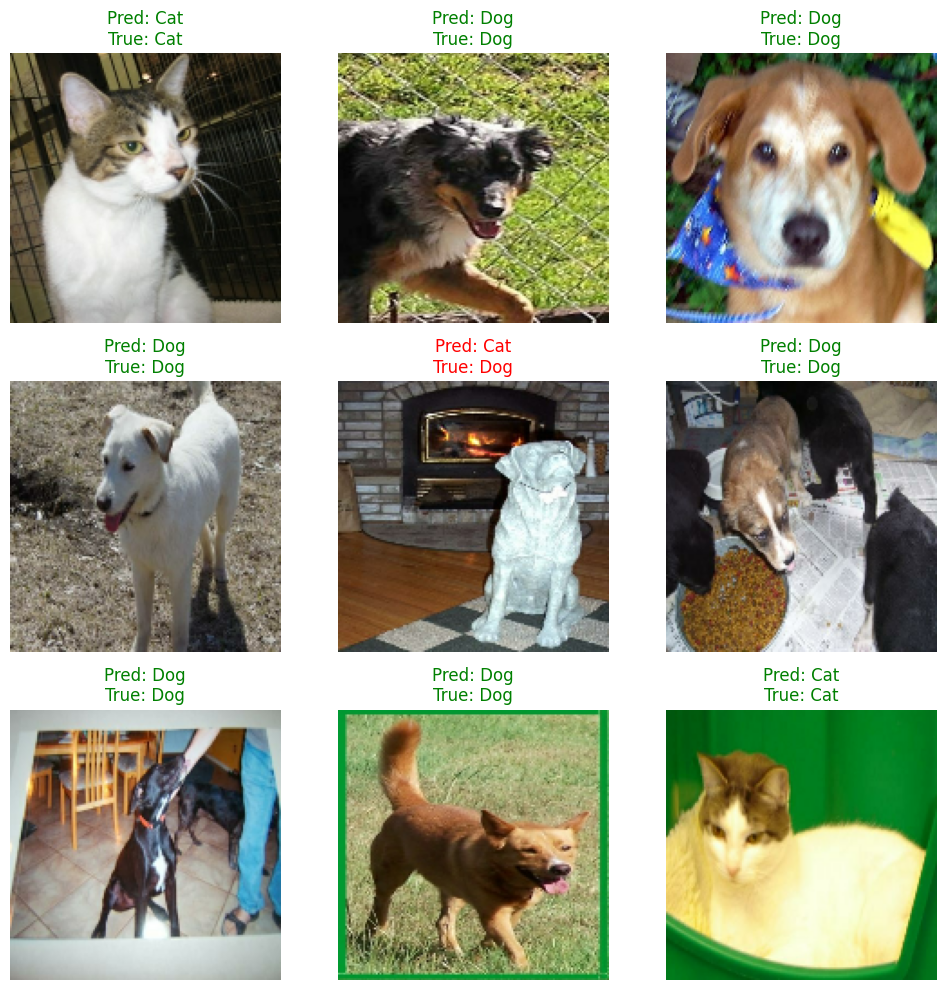

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = "Dog" if predictions[i] > 0 else "Cat"
        true_class = "Dog" if labels[i] == 1 else "Cat"
        color = "green" if predicted_class == true_class else "red"
        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()

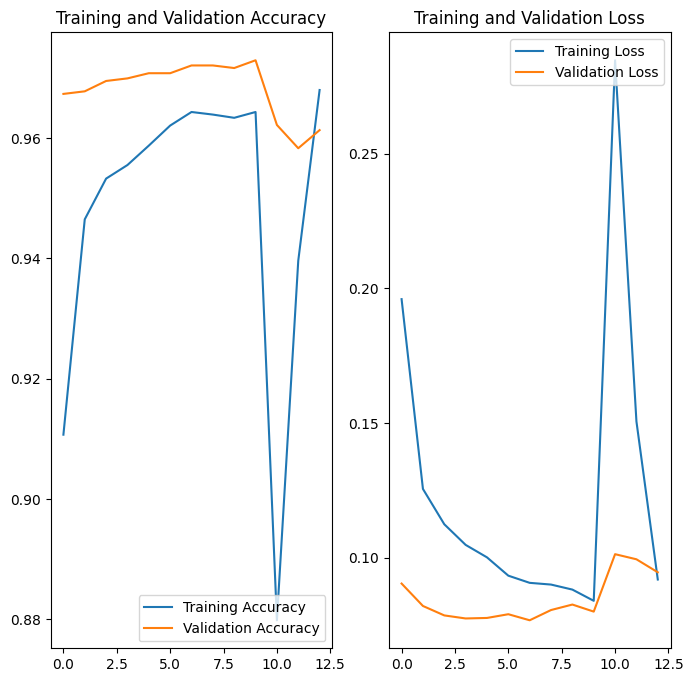

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
def plot_training(history1, history2):
    acc1 = history1.history['binary_accuracy']
    val_acc1 = history1.history['val_binary_accuracy']
    acc2 = history2.history['binary_accuracy']
    val_acc2 = history2.history['val_binary_accuracy']

    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    total_acc = acc1 + acc2
    total_val_acc = val_acc1 + val_acc2
    total_loss = loss1 + loss2
    total_val_loss = val_loss1 + val_loss2

    epochs_range = range(len(total_acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, total_acc, label='Training Accuracy')
    plt.plot(epochs_range, total_val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, total_loss, label='Training Loss')
    plt.plot(epochs_range, total_val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Gọi hàm để vẽ biểu đồ
plot_training(history_1, history_2)


#Nhận xét

**Phần đóng băng Base Model**
Tổng số: 20,863,529 tham số

Trainable params: 2,049 (lớp trên cùng)

Non-trainable params: 20,861,480 (base model - Xception đã được đóng băng)

Mặc dù ban đầu mô hình không ổn định (epoch 3), nhưng sau đó mô hình đã tự điều chỉnh và ổn định lại với val_binary_accuracy đạt mức khoảng 95-96% trong các epoch cuối cùng.

Validation loss tuy giảm nhưng vẫn còn một chút dao động trong các epoch cuối (0.1524 đến 0.2491), cho thấy mô hình đã học khá tốt nhưng vẫn còn khoảng không để cải thiện.

**Phần không đóng băng Base Model**
Việc huấn luyện toàn bộ mô hình (bao gồm cả base model) đã giúp cải thiện độ chính xác của mô hình, cả trên tập huấn luyện và tập validation.

Val_binary_accuracy đạt gần 97% và val_loss giảm xuống mức thấp ổn định, cho thấy mô hình đã hoạt động tốt hơn sau khi base model được huấn luyện lại.

Sự cải thiện này chứng tỏ việc huấn luyện thêm base model là hiệu quả và mô hình đã học được các đặc trưng quan trọng từ dữ liệu huấn luyện.

**Kết luận**
Trong giai đoạn đầu khi base model bị đóng băng, mô hình đã đạt được độ chính xác khá tốt trên cả tập huấn luyện và validation, nhưng có một vài vấn đề về mất ổn định ở giai đoạn ban đầu.

Khi base model được mở ra và huấn luyện thêm, mô hình đã cải thiện đáng kể về cả độ chính xác và độ ổn định, đạt gần 97% trên tập validation với loss thấp. Điều này cho thấy việc huấn luyện thêm base model là cần thiết để cải thiện hiệu suất tổng thể của mô hình.

**1. Training and Validation Accuracy**

Training Accuracy có xu hướng tăng dần đều và đạt khoảng gần 100%, cho thấy mô hình đang học rất tốt trên tập huấn luyện.

Validation Accuracy ban đầu dao động mạnh, giảm mạnh ở epoch đầu tiên nhưng sau đó tăng dần lên và ổn định quanh mức 95%. Điều này cho thấy mô hình có khả năng tổng quát hóa tốt trên tập validation, mặc dù có chút dao động nhẹ.

**2. Training and Validation Loss:**

Training Loss giảm dần đều, điều này phù hợp với việc Training Accuracy tăng lên.

Validation Loss bắt đầu rất cao (khoảng 3.0), có thể do sự dao động của quá trình tối ưu hóa. Sau đó, nó giảm mạnh và tiếp tục dao động ở mức thấp hơn (dưới 0.5). Điều này có thể là dấu hiệu của sự không ổn định trong giai đoạn đầu của quá trình huấn luyện, nhưng mô hình dần ổn định lại.

**3. Sự không ổn định ban đầu:**

Ở những epoch đầu tiên, cả Validation Accuracy và Validation Loss đều có sự biến động mạnh, đặc biệt là ở epoch thứ 2 và 3. Đây có thể là dấu hiệu của việc mô hình gặp khó khăn trong việc học các đặc trưng tốt từ đầu, nhưng dần dần mô hình đã học được và ổn định hơn.